In [2]:
#import necessary packages
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz

In [3]:
import urllib.request, urllib.parse
from urllib.error import HTTPError,URLError

def get_countries_data():
    """
    Function to get information like population from all countries
    """
    url = 'https://restcountries.eu/rest/v2/all'
    try:
        uh = urllib.request.urlopen(url)
    except HTTPError as e:
        print("Sorry! Could not retrive anything on {}".format(country_name))
        return None
    except URLError as e:
        print('Failed to reach a server.')
        print('Reason: ', e.reason)
        return None
    else:
        data = uh.read().decode()
        return data

In [4]:
countries_data = get_countries_data()

In [5]:
#make a request to worldometers coronavirus page
worldo = requests.get('https://www.worldometers.info/coronavirus/')

In [6]:
#Parse the page using beautifulsoup and extract the table containing covid-19 cases
soup = BeautifulSoup(worldo.text, 'lxml')
table = soup.find_all('table')
#Create a pandas dataframe object out of the parsed page
worldometer_dataframe = pd.read_html(str(table))[0]
columns = ['Country', 'Total Cases', 'Drop1', 'Total Deaths', 
           'Drop2', 'Total Recovered', 'Active Cases', 'Serious / Critical Cases', 'Drop3', 'Drop4', 'Total Tests', 'Drop5']
worldometer_dataframe.columns = columns
worldometer_dataframe.drop(['Drop1', 'Drop2', 'Drop3', 'Drop4', 'Drop5'], axis=1, inplace=True)
worldometer_dataframe.drop([0, len(worldometer_dataframe.index) -1 ], inplace=True)#Remove the first and last rows from thetable

In [7]:
population_json = json.loads(countries_data)
worldometer_json = json.loads(worldometer_dataframe.to_json(orient="records"))

In [8]:
countries =[{'name': country['name'] ,'alt': country['altSpellings'] , 'native name': country['nativeName'], 'population': country['population']} for country in population_json]

for each_dict in worldometer_json:#First iteration that compares the country name in the worldometer table to the country name gotten from restcountries.eu api
    for country in countries:
        if (each_dict['Country'] == country['name']) or (each_dict['Country'] == country['native name']):
            each_dict['population'] = country['population']
            countries.remove(country)#remove the country from the list to make it smaller

for each_dict in worldometer_json:
    if 'population' not in each_dict:
        for country in countries:
            if(fuzz.partial_ratio(each_dict['Country'], country['name']) == 100):
                each_dict['population'] = country['population']
                countries.remove(country)
                
for each_dict in worldometer_json:
    if 'population' not in each_dict:
        for country in countries:
            if each_dict['Country'] in country['alt']:
                each_dict['population'] = country['population']
                countries.remove(country)
                         
mapping = {'S. Korea' : 'Korea (Republic of)', 
           'Czechia': 'Czech Republic', 
           'Vietnam' : 'Viet Nam', 
           'North Macedonia': 'Macedonia (the former Yugoslav Republic of)'}

for each_dict in worldometer_json:
    if ('population' not in each_dict) and (each_dict['Country'] in mapping):
        for country in countries: 
            if (country['name'] == mapping[each_dict['Country']]):
                each_dict['population'] = country['population']
                countries.remove(country)

In [9]:
corona_virus_detailed_table = pd.DataFrame(worldometer_json)
corona_virus_detailed_table.sort_values(by='Total Cases', ascending=False, inplace=True)
corona_virus_detailed_table.index = range(1, len(worldometer_dataframe) + 1)
corona_virus_detailed_table.head()

,Country,Total Cases,Total Deaths,Total Recovered,Active Cases,Serious / Critical Cases,Total Tests,population
1,USA,1132038,65783.0,161666.0,904589,16481.0,6700781.0,323947000.0
2,Spain,245567,25100.0,146233.0,74234,2500.0,1528833.0,46438422.0
3,Italy,207428,28236.0,78249.0,100943,1578.0,2053425.0,60665551.0
4,UK,177454,27510.0,NaN,149600,1559.0,1023824.0,65110000.0
5,France,167346,24594.0,50212.0,92540,3878.0,1100228.0,66710000.0


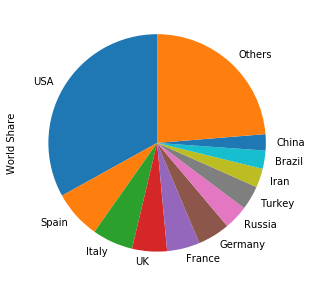

In [10]:
columns = ['Country', 'Total Cases']
countries_world_share = pd.DataFrame(corona_virus_detailed_table, columns = columns)
countries_world_share['World Share'] = countries_world_share['Total Cases'] / sum(countries_world_share['Total Cases']) * 100
more_than_2 = countries_world_share[countries_world_share['World Share'] >= 2]
less_than_2 = countries_world_share[countries_world_share['World Share'] < 2]
others = pd.DataFrame({'Country' : 'Others', 'Total Cases' : less_than_2['Total Cases'].sum(), 
                       'World Share': less_than_2['World Share'].sum()}, index=[len(more_than_2) + 1])

world_share_aggregate = pd.concat([more_than_2, others], axis=0)
world_share_aggregate.set_index('Country').plot.pie(y='World Share', figsize=(5,5), startangle=90, legend=False)
plt.show()

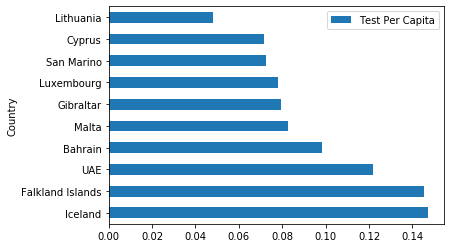

In [14]:
tests_per_capita_table = pd.DataFrame(corona_virus_detailed_table, columns=['Country','Total Tests', 'population'])
tests_per_capita_table['Test Per Capita'] = tests_per_capita_table['Total Tests']/tests_per_capita_table['population']
tests_per_capita_table.sort_values(by='Test Per Capita', ascending=False, inplace=True)
tests_per_capita_table.index = range(1, len(tests_per_capita_table) + 1)
tests_per_capita_table.head(10).plot.barh(x='Country', y='Test Per Capita')

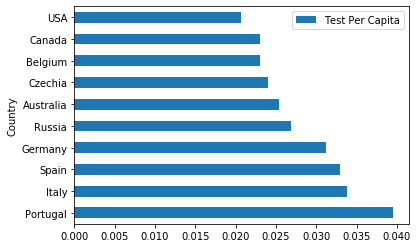

In [15]:
tpct_over_ten_million = tests_per_capita_table[tests_per_capita_table['population'] >= 10000000]
tpct_over_ten_million.index = range(1, len(tpct_over_ten_million) + 1)
tpct_over_ten_million.head(10).plot.barh(x='Country', y='Test Per Capita')

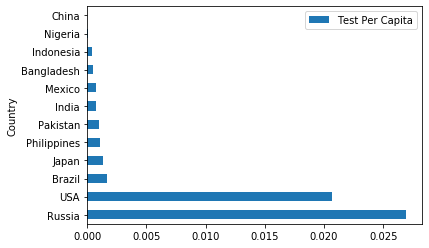

In [18]:
tpct_over_hundred_million = tests_per_capita_table[tests_per_capita_table['population'] >= 100000000]
tpct_over_hundred_million.index = range(1, len(tpct_over_hundred_million) + 1)
tpct_over_hundred_million.head(15).plot.barh(x='Country', y='Test Per Capita')

In [20]:
death_rate = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Total Deaths'])
death_rate['Death Rate'] = (death_rate['Total Deaths'] / death_rate['Total Cases']) * 100
death_rate.sort_values(by='Death Rate', ascending=False, inplace=True)
death_rate = death_rate[death_rate['Total Cases'] >= 1000]
death_rate.index = range(1, len(death_rate) + 1)
death_rate.head()

,Country,Total Cases,Total Deaths,Death Rate
1,Belgium,49517,7765.0,15.681483
2,UK,177454,27510.0,15.502609
3,France,167346,24594.0,14.696497
4,Italy,207428,28236.0,13.612434
5,Netherlands,40236,4987.0,12.394373


In [21]:
percentage_recovered = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Total Recovered'])
percentage_recovered['Percentage Recovered'] = (percentage_recovered['Total Recovered']/percentage_recovered['Total Cases']) * 100
percentage_recovered.sort_values(by='Percentage Recovered', ascending=False, inplace=True)
percentage_recovered.index = range(1, len(percentage_recovered) + 1)
percentage_recovered.head(10)

,Country,Total Cases,Total Recovered,Percentage Recovered
1,Anguilla,3,3.0,100.000000
2,St. Barth,6,6.0,100.000000
3,Greenland,11,11.0,100.000000
4,Falkland Islands,13,13.0,100.000000
5,Faeroe Islands,187,184.0,98.395722
6,Cambodia,122,120.0,98.360656
7,New Caledonia,18,17.0,94.444444
8,Mauritius,332,312.0,93.975904
9,Iceland,1798,1689.0,93.937709
10,China,82875,77685.0,93.737557


In [25]:
active_table = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'Active Cases', 'Serious / Critical Cases'])
active_table['% Active(of Total Cases)'] = (active_table['Active Cases']/active_table['Total Cases']) * 100
active_table['% Critical(of active)'] = (active_table['Serious / Critical Cases']/active_table['Active Cases']) * 100
# active_table.sort_values(by='% Critical(of active)', ascending=False, inplace=True)
# active_table.index = range(1, len(active_table) + 1)
active_table.head()

,Country,Total Cases,Active Cases,Serious / Critical Cases,% Active(of Total Cases),% Critical(of active)
1,USA,1132038,904589,16481.0,79.908007,1.821932
2,Spain,245567,74234,2500.0,30.229632,3.367729
3,Italy,207428,100943,1578.0,48.664115,1.563258
4,UK,177454,149600,1559.0,84.303538,1.042112
5,France,167346,92540,3878.0,55.298603,4.190620


In [30]:
cases_per_capita = pd.DataFrame(corona_virus_detailed_table, columns=['Country', 'Total Cases', 'population'])
cases_per_capita['Cases Per Capita'] = cases_per_capita['Total Cases'] / cases_per_capita['population']
cases_per_capita.sort_values(by='Cases Per Capita', ascending=False, inplace=True)
cases_per_capita.index = range(1, len(cases_per_capita) + 1)
cases_per_capita.head(15).plot.barh(x='Country', y='Cases Per Capita')

0.0008457078031674277

In [24]:
# corona_virus_detailed_table[corona_virus_detailed_table['population'].isna() ]
# corona_virus_detailed_table[corona_virus_detailed_table['Country'].isin([ 'S. Korea', 'Czechia', 'Vietnam', 'North Macedonia'])  ]